#### 6610402230 Sirisuk Tharntham

# Assignment 5: WordEmbedding

# **Setup**

In [46]:
# download data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo' -O w_review_train.csv

# download font for matplot
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DsfYE5uI1ZA_IXDNkezQTv-NQehxgZQy' -O THSarabun.ttf

# install library
!pip install gensim
!pip install pythainlp

--2024-07-31 20:08:46--  https://docs.google.com/uc?export=download&id=1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo
Resolving docs.google.com (docs.google.com)... 2404:6800:4001:810::200e, 172.217.26.78
Connecting to docs.google.com (docs.google.com)|2404:6800:4001:810::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo&export=download [following]
--2024-07-31 20:08:46--  https://drive.usercontent.google.com/download?id=1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2404:6800:4001:80e::2001, 216.58.221.193
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2404:6800:4001:80e::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60418516 (58M) [application/octet-stream]
Saving to: ‘w_review_train.csv’

w_review_train.csv  100%[===================>]  57.62M 

In [1]:
from gensim.models import Word2Vec

from pythainlp import word_tokenize
from pythainlp.util import dict_trie
from pythainlp.corpus.common import thai_words
from pythainlp.corpus import thai_stopwords

import pandas as pd
import numpy as np
import re

from sklearn.decomposition import PCA #reduce dimension for eg in SVD
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

%matplotlib inline

# **loading** **data**

In [2]:
train = pd.read_csv("w_review_train.csv",  encoding='utf8', names=["sentence"])
train.head(10)

,sentence
0,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...
1,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...
2,ปอเปี๊ยะสด ทุกวันนี้รู้สึกว่าหากินยาก (ร้านที่...
3,รัานคัพเค้กในเมืองไทยมีไม่มาก หลายๆคนอาจจะสงสั...
4,อร่อย!!! เดินผ่านDigital gatewayทุกวัน ไม่ยักร...
5,ร้านข้าวต้มกระดูกหมู ปากซอยพัฒนาการ 57 เป็นอีก...
6,วันนี้ได้มีโอกาสไปนั่งซดกาแฟที่ร้านวาวี แถวๆอา...
7,สารภาพว่าไม่เคยคิดจะไปต่อคิวซื้อมากินเองครับ บ...
8,เมื่อวันก่อนไปเดินเล่น แบบชิวๆๆ ที่สยามสแควร์แ...
9,วันก่อนไปเดินสยาม หลังจากห่างหายไป ประมาณ 6 เด...


In [3]:
train.shape

(40000, 1)

# **Creating model and training model using gensim**

In [4]:
# add word to dict
words = ['บะหมี่แห้ง', 'ข้าวหมูกรอบ', 'ก๋วยเตี๋ยวหมูต้มยำ', 'ปลากระพงทอดน้ำปลา', 'ซูชิ', 'กาแฟ', 'ชานมไข่มุก', 'เค้กช็อกโกแลต', 'เครปเค๊ก', 'ไอศครีม']
custom_words_list = set(thai_words())
custom_words_list.update(words)
trie = dict_trie(dict_source=custom_words_list)

In [5]:
STOP_WORD = list(thai_stopwords()) + [" ", "\n"]

FORMAT = r"[\u0E00-\u0E7Fa-zA-Z'0-9]+"

In [6]:
def tokenize(sentence):
  return word_tokenize(sentence, engine="newmm", custom_dict=trie)

def cleaning_stop_word(tk_list):
  return [word for word in tk_list if word not in STOP_WORD]

def cleaning_symbols_emoji(tk_list):
  return [re.findall(FORMAT, text)[0] for text in tk_list if re.findall(FORMAT, text)]

**Word2Vec Function:**
* **tokenized_list** เป็นข้อมูลที่ใช้ train โมเดล โดยจะอยู่ในลักษณะของ list ของ list ของ tokens (คำในแต่ละรีวิว)

* **vector_size** เป็นจำนวนมิติของ embedding layer (ขนาดของ embedded  vector) ที่ต้องการ

* **window** คือจำนวนคำใกล้เคียงที่เกิดขึ้นร่วมกันกับคำที่กำลังฝึกฝนอยู่

* **min_count** คือ จำนวนขั้นต่ำของคำที่ปรากฎในข้อมูลการ train ทั้งหมด (คำที่ปรากฎน้อยจะไม่สนใจ)

* **worker** คือจำนวนของ computer threads ที่จะใช้ในการ train

* **sg** คือ ถ้า =0 คือ train ด้วย CBOW, =1 คือ train ด้วย Skip-gram (ปกติ Skip-gram จะใช้เวลา train นานกว่า CBOW)

* **epochs** คือ จำนวนรอบที่โมเดลจะ train ข้อมูล

In [7]:
import os, random, numpy as np
import tensorflow as tf

seed_value = 7777
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

In [8]:
def previewWordVector(wv ,maxIdx):
    for index, word in enumerate(wv.index_to_key):
        if index == maxIdx:
            break
        print(f"word #{index}/{len(wv.index_to_key)} is {word}")    


### Model 1

In [9]:
# model 1: doesn't clean anything

#### Your Code ####
train_tokenize = train["sentence"].apply(tokenize)

In [10]:
print(train_tokenize.head())

0    [ร้านอาหาร, ใหญ่, มาก, กก, กก, กก,  , \n, เลี้...
1    [อาหาร, ที่นี่, เป็น, อาหารจีน, แคะ, ที่, หากิ...
2    [ปอเปี๊ยะ, สด,  , ทุกวันนี้, รู้สึก, ว่า, หากิ...
3    [รัาน, คัพ, เค้ก, ใน, เมือง, ไทย, มี, ไม่, มาก...
4    [อร่อย, !!!,  , เดินผ่าน, Digital,  , gateway,...
Name: sentence, dtype: object


In [11]:
from gensim.models import Word2Vec

model1 = Word2Vec(train_tokenize,vector_size=50,window=4,min_count=1,workers=100,sg=1, epochs=5)

In [12]:
wv = model1.wv
previewWordVector(wv,5)
print(wv["อาหาร"])

word #0/54900 is  
word #1/54900 is 

word #2/54900 is ร้าน
word #3/54900 is ไม่
word #4/54900 is มา
[-0.47748637  0.01244237 -0.2711138   0.24541731  0.5722588  -0.40346113
  0.32603857  0.35009867 -0.5820017   0.11488509  0.5635005  -0.94204617
 -0.2988499   0.77551824 -0.5990218   0.7279703  -0.18633261  0.71754164
 -0.6147806  -0.44736582  0.3280839   0.699006   -0.3854325   0.03201395
  0.31035468  0.08125116 -0.44336197  0.30408454 -0.45511317 -0.51371753
 -0.1621149   0.19754297  0.25424716 -0.35986754  0.19666876 -0.09153117
  0.6695385  -0.6631639   0.05017967  0.1080331   0.05661752 -0.47936523
 -0.29736865  0.67647684  0.26315427 -0.03042554 -0.03282813 -0.10064186
  0.2513039   0.01594198]


### Model 2

In [13]:
# model 2: only cleaning stopword

# def tk_with_no_stop_word(sentence):
#   return cleaning_stop_word( tokenize(sentence) )

#### Your Code ####
train_tokenized_no_stop_word = cleaning_stop_word(train_tokenize)

In [14]:
from gensim.models import Word2Vec

model2 = Word2Vec(train_tokenized_no_stop_word,vector_size=50,window=4,min_count=1,workers=100,sg=1, epochs=5)

In [15]:
wv = model2.wv
previewWordVector(wv,5)
print(wv["อาหาร"])

word #0/54900 is  
word #1/54900 is 

word #2/54900 is ร้าน
word #3/54900 is ไม่
word #4/54900 is มา
[-0.15518737 -0.03228328 -0.20096375  0.0944508   0.54783714 -0.11941869
  0.34724236  0.10520632 -0.6873176  -0.07435749  0.06757584 -1.1398281
 -0.2830929   0.6852449  -0.6412509   0.6442048   0.26298654  0.44369692
 -0.4590009  -0.27487662  0.49520072  0.77375746  0.19899483  0.1550035
  0.58754647  0.11979528 -0.71520835  0.61535084 -0.19459803 -0.5189966
 -0.13925707  0.02949203  0.36613834 -0.21905181  0.21842375  0.14076002
  0.93172777 -0.529601    0.00312542  0.3214572   0.11164523  0.06778776
 -0.31920266  0.12616383  0.40425923 -0.08020818 -0.5533592  -0.19504887
  0.4439403  -0.08917651]


### Model 3

In [16]:
# model 3: only cleaning symbols and emoji

# def tk_with_no_symbols(sentence):
#   return cleaning_symbols_emoji( tokenize(sentence) )
def cleaning_symbols_emoji(tk_list):
  return [[w for w in words if re.findall(FORMAT, w)] for words in tk_list]

#### Your Code ####

train_tokenized_no_symbols = cleaning_symbols_emoji(train_tokenize)

In [17]:
from gensim.models import Word2Vec

model3 = Word2Vec(train_tokenized_no_symbols,vector_size=50,window=4,min_count=1,workers=100,sg=1, epochs=5)

In [18]:
wv = model3.wv
previewWordVector(wv,5)
print(wv["อาหาร"])

word #0/53526 is ร้าน
word #1/53526 is ไม่
word #2/53526 is มา
word #3/53526 is ที่
word #4/53526 is มี
[-0.15827067  0.2876516   0.42976388 -0.18773039 -0.52401143 -0.40922898
  0.6098889   0.7941266  -0.25068316 -0.16820033  0.24205284 -0.5241019
  0.45509392 -0.28928375 -0.4328505   0.6879953   0.05484349  0.18992095
 -0.40533176 -0.7749699   0.19203047  0.55135864  0.5908521   0.13159306
  0.40875116  0.24282075 -0.5186759   0.17847428  0.16735315 -0.29015043
 -0.31358016 -0.18453975 -0.07482708  0.02558511 -0.2681252   0.10128131
  0.5416131   0.13197634  0.22298977  0.49490574  0.72383934 -0.5441267
 -0.15299934 -0.20897412  1.0138297   0.12209356  0.10505857 -0.5235338
 -0.15407634  0.33900392]


### Model 4

In [19]:
# model 4: cleaning stopword, symbols and emoji and more train wongnai to pretrained model

# load pretrained model
model4 = Word2Vec.load('http://www.arts.chula.ac.th/ling/wp-content/uploads/TNCc5model.bin')

def big_cleaning(sentence):
  return  cleaning_symbols_emoji( cleaning_stop_word( tokenize(sentence) ) )

#### Your Code ####
train_tokenize_clean_all = cleaning_symbols_emoji(train_tokenized_no_stop_word)

In [20]:
model4.build_vocab(train_tokenize_clean_all, update=True)
model4.train(train_tokenize_clean_all, total_examples=model4.corpus_count, epochs=model4.epochs)

(20369889, 25515910)

In [21]:
wv = model4.wv
previewWordVector(wv,5)
print(wv["อาหาร"])

word #0/40024 is ที่
word #1/40024 is การ
word #2/40024 is เป็น
word #3/40024 is ใน
word #4/40024 is ของ
[-0.880989    1.2975591   0.9864945   0.98591924  1.3960701  -0.33547124
  1.0183349  -1.0187572   1.7463013  -0.6863928   0.1772649   1.4438419
  2.165188   -1.2425938  -1.8577445  -1.1334541  -0.35508364 -0.886836
  1.0478745   0.70365804 -0.0752771   0.39636728 -0.6565624   0.6053457
 -0.5167487   0.6615184  -1.9134151   1.6657377  -0.41067153  1.2146685
 -1.1985123   0.13993625  0.06176215 -1.0664694  -1.3300966  -0.21420243
  0.7075558   1.0351586  -0.9140384  -1.5835049  -0.3071141   0.5378934
 -1.4473917   0.8231433   0.27600652 -0.30745506  0.8708476  -1.4095234
 -0.95776725  1.0708016  -1.3986913  -1.7800333   0.65581894  0.09547884
 -1.2983816   0.29115516 -2.4932992   0.27889743  0.20022452  1.1945916
  1.2035794   1.3707162   2.4397018   1.5829446   1.8144782   1.0150609
  1.3679563  -0.5418231  -2.910631    0.48566914  0.27148458 -2.4288087
 -0.53761685  0.3696385  -3.6

### TEST Similarity

In [22]:
# word similarity
print(model1.wv.similarity('อร่อย', 'สุดยอด'))
print(model2.wv.similarity('อร่อย', 'สุดยอด'))
print(model3.wv.similarity('อร่อย', 'สุดยอด'))
print(model4.wv.similarity('อร่อย', 'สุดยอด'))

0.8350995
0.7999787
0.8066021
0.46355674


In [23]:
print("doesn't clean anything:" , model1.wv.most_similar("ชานมไข่มุก", topn=5))
print("only cleaning stopword:" , model2.wv.most_similar("ชานมไข่มุก", topn=5))
print("only cleaing symbols and emoji:" , model3.wv.most_similar("ชานมไข่มุก", topn=5))
print("cleaning stopword, symbols and emoji:" , model4.wv.most_similar("ชานมไข่มุก", topn=5))

doesn't clean anything: [('ชาเย็น', 0.8245267868041992), ('ไข่มุก', 0.8209906816482544), ('นม', 0.8172247409820557), ('ชาเขียว', 0.8115327954292297), ('ชามะลิ', 0.8040582537651062)]
only cleaning stopword: [('ชาเย็น', 0.8410789966583252), ('นม', 0.8125903606414795), ('ชาเขียว', 0.8076897263526917), ('โกโก้', 0.8066887855529785), ('ไข่มุก', 0.8058604001998901)]
only cleaing symbols and emoji: [('ชาเย็น', 0.8476288914680481), ('นม', 0.825415849685669), ('Dakasi', 0.8176328539848328), ('ชาเขียว', 0.8078790307044983), ('นมสด', 0.8073645830154419)]
cleaning stopword, symbols and emoji: [('กาแฟเย็น', 0.622780442237854), ('ชาเย็น', 0.6215293407440186), ('โกโก้', 0.5516364574432373), ('Rose', 0.5482050776481628), ('ชาเขียว', 0.5477891564369202)]


In [24]:
print("doesn't clean anything:" , model1.wv.most_similar("บะหมี่แห้ง", topn=5))
print("only cleaning stopword:" , model2.wv.most_similar("บะหมี่แห้ง", topn=5))
print("only cleaing symbols and emoji:" , model3.wv.most_similar("บะหมี่แห้ง", topn=5))
print("cleaning stopword, symbols and emoji:" , model4.wv.most_similar("บะหมี่แห้ง", topn=5))

doesn't clean anything: [('บะหมี่', 0.9081555008888245), ('เย็นตาโฟ', 0.8668094277381897), ('อัศวิน', 0.8627094626426697), ('เส้นใหญ่', 0.8618103861808777), ('หมูแดง', 0.8598599433898926)]
only cleaning stopword: [('บะหมี่', 0.898272693157196), ('เส้นใหญ่', 0.8745819926261902), ('เย็นตาโฟ', 0.8692036867141724), ('หยก', 0.8617921471595764), ('เกาเหลา', 0.8601693511009216)]
only cleaing symbols and emoji: [('บะหมี่', 0.9095541834831238), ('เส้นใหญ่', 0.868003785610199), ('อัศวิน', 0.8628929257392883), ('หยก', 0.8602696657180786), ('เกี๋ยว', 0.8448532819747925)]
cleaning stopword, symbols and emoji: [('เส้นใหญ่', 0.7265085577964783), ('ข้าวหมูกรอบ', 0.6876041889190674), ('กระเพาะปลา', 0.6840742826461792), ('เย็นตาโฟ', 0.6821058988571167), ('บะหมี่', 0.68180912733078)]


In [25]:
print("doesn't clean anything:" , model1.wv.most_similar('ปลากระพงทอดน้ำปลา', topn=5))
print("only cleaning stopword:" , model2.wv.most_similar('ปลากระพงทอดน้ำปลา', topn=5))
print("only cleaing symbols and emoji:" , model3.wv.most_similar('ปลากระพงทอดน้ำปลา', topn=5))
print("cleaning stopword, symbols and emoji:" , model4.wv.most_similar('ปลากระพงทอดน้ำปลา', topn=5))

doesn't clean anything: [('ทอดมันปลากราย', 0.9162781834602356), ('กุ้งแช่น้ำปลา', 0.8763739466667175), ('สำลี', 0.8660990595817566), ('ฉู่ฉี่', 0.8642923831939697), ('มันปลา', 0.8632799983024597)]
only cleaning stopword: [('ทอดมันปลากราย', 0.9107829928398132), ('ทอดมัน', 0.8834150433540344), ('กุ้งแช่น้ำปลา', 0.8827821612358093), ('ต้มส้ม', 0.8823398947715759), ('ฉู่ฉี่', 0.8806170225143433)]
only cleaing symbols and emoji: [('ทอดมันปลากราย', 0.891605019569397), ('เนื้ออ่อน', 0.889254629611969), ('ฉู่ฉี่', 0.8828052282333374), ('กะพง', 0.876541256904602), ('แป๊ะซะ', 0.8765168190002441)]
cleaning stopword, symbols and emoji: [('ทอดมันปลากราย', 0.7746560573577881), ('ปลาทู', 0.7144774794578552), ('ทอดมัน', 0.7010828852653503), ('ปูม้า', 0.699662983417511), ('ต้มยำกุ้ง', 0.6923584342002869)]


In [26]:
print("doesn't clean anything:" , model1.wv.most_similar('ซูชิ', topn=5))
print("only cleaning stopword:" , model2.wv.most_similar('ซูชิ', topn=5))
print("only cleaing symbols and emoji:" , model3.wv.most_similar('ซูชิ', topn=5))
print("cleaning stopword, symbols and emoji:" , model4.wv.most_similar('ซูชิ', topn=5))

doesn't clean anything: [('ปลาดิบ', 0.938763439655304), ('ข้าวปั้น', 0.9222504496574402), ('แซลมอน', 0.8759046792984009), ('ปลาไหล', 0.8557061553001404), ('ซา', 0.8426666259765625)]
only cleaning stopword: [('ปลาดิบ', 0.9274121522903442), ('ข้าวปั้น', 0.9243993759155273), ('แซลมอน', 0.8603982925415039), ('เบนโตะ', 0.8520441651344299), ('ปลาไหล', 0.8384311199188232)]
only cleaing symbols and emoji: [('ปลาดิบ', 0.9285014271736145), ('ข้าวปั้น', 0.92078697681427), ('แซลมอน', 0.860608696937561), ('ปลาไหล', 0.8590394854545593), ('ปั้นหน้า', 0.846375584602356)]
cleaning stopword, symbols and emoji: [('ข้าวปั้น', 0.8391844034194946), ('ปลาดิบ', 0.7874991297721863), ('ปลาไหล', 0.7118473052978516), ('แซลมอน', 0.6943140625953674), ('ฟัวกราส์', 0.5841503143310547)]


# **Visualization**


In [27]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [28]:
plt.style.use('seaborn-v0_8-notebook')

# setup font for matplotlib
thai_sarabun = FontProperties(fname="THSarabun.ttf", size=18)

In [29]:
# using PCA

def display_plot(words):
  models = [model1, model2, model3, model4]
  fig, axes = plt.subplots(2, 2, figsize=(14, 14))

  j, k = 0, 0

  for modelx in models:
      if k == 2:
        k = 0
        j = 1

      word_vectors = np.array( [ modelx.wv[w] for w in words ])

      twodim = PCA().fit_transform(word_vectors)[:,:2]

      axes[j][k].scatter(twodim[:,0], twodim[:,1], c='salmon')
      for word, (x,y) in zip(words, twodim):
        axes[j][k].text(x+0.05, y+0.05, word, fontproperties=thai_sarabun)

      k += 1

  axes[0][0].set_title("Model 1: doesn't clean anything")
  axes[0][1].set_title("Model 2: only cleaning stopword")
  axes[1][0].set_title("Model 3: only cleaing symbols and emoji")
  axes[1][1].set_title("Model 4: cleaning stopword, symbols and emoji")


### Example Plot

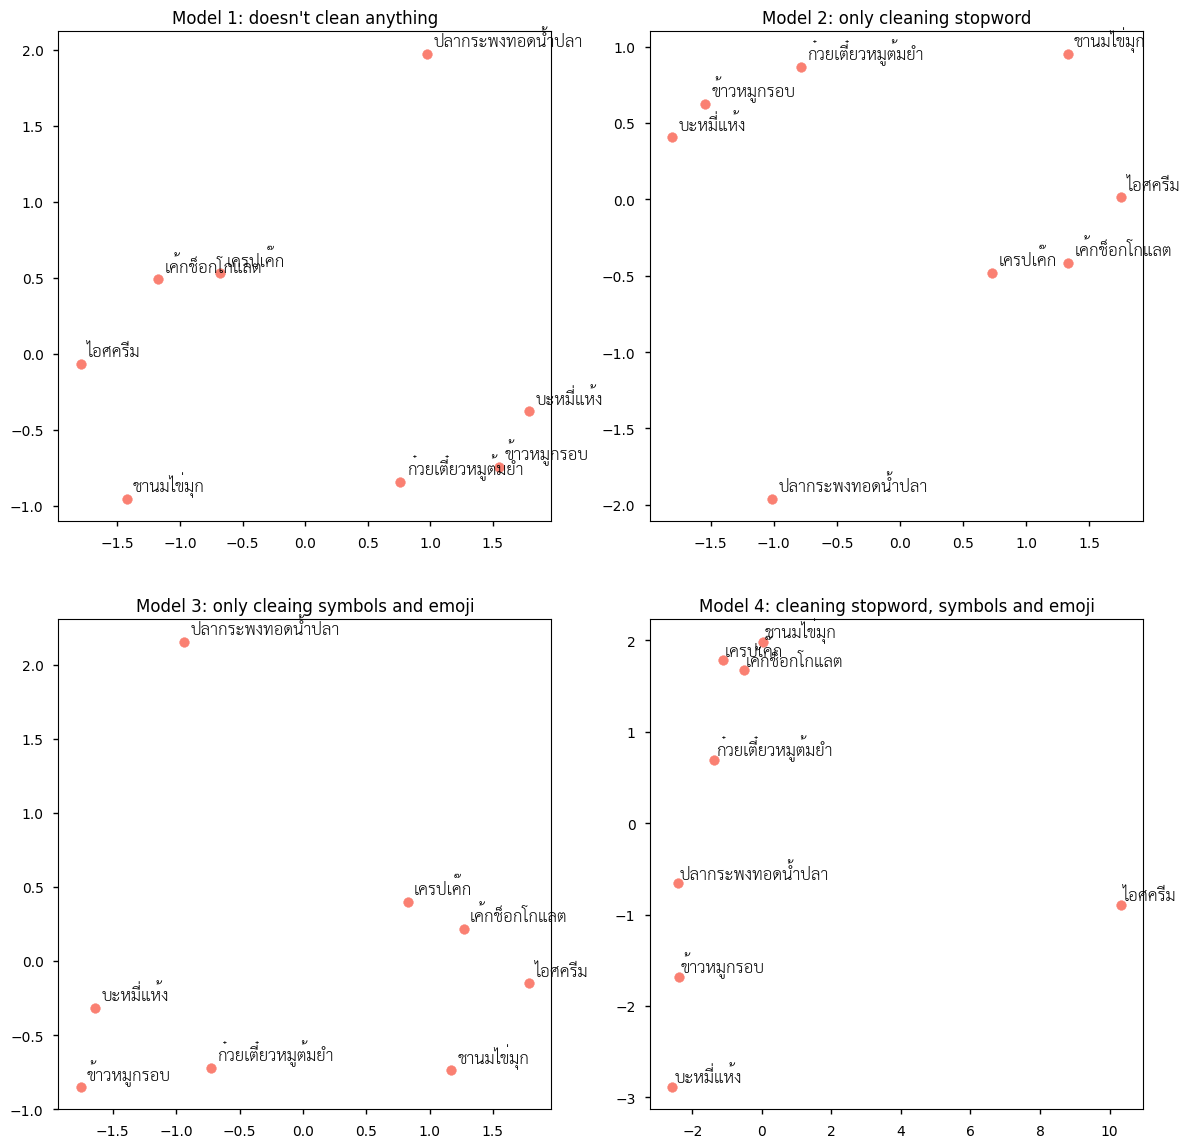

In [30]:
words = ['บะหมี่แห้ง', 'ข้าวหมูกรอบ', 'ก๋วยเตี๋ยวหมูต้มยำ', 'ปลากระพงทอดน้ำปลา', 'ชานมไข่มุก', 'เค้กช็อกโกแลต', 'เครปเค๊ก', 'ไอศครีม']
display_plot(words)

### My plot

In [31]:
def findSimilar(word,n):
    print("doesn't clean anything:" , model1.wv.most_similar(word, topn=n))
    print("only cleaning stopword:" , model2.wv.most_similar(word, topn=n))
    print("only cleaing symbols and emoji:" , model3.wv.most_similar(word, topn=n))
    print("cleaning stopword, symbols and emoji:" , model4.wv.most_similar(word, topn=n))
    print()

words = ['บะหมี่แห้ง', 'ข้าวหมูกรอบ', 'ก๋วยเตี๋ยวหมูต้มยำ', 'ปลากระพงทอดน้ำปลา', 'ชานมไข่มุก', 'เค้กช็อกโกแลต', 'เครปเค๊ก', 'ไอศครีม']
for word in words:
    findSimilar(word,10)
    

doesn't clean anything: [('บะหมี่', 0.9081555008888245), ('เย็นตาโฟ', 0.8668094277381897), ('อัศวิน', 0.8627094626426697), ('เส้นใหญ่', 0.8618103861808777), ('หมูแดง', 0.8598599433898926), ('หยก', 0.8575751185417175), ('เกาเหลา', 0.8573006987571716), ('เส้นหมี่', 0.8569333553314209), ('เกี้ยมอี๋', 0.8510032892227173), ('เกี๊ยว', 0.8494611978530884)]
only cleaning stopword: [('บะหมี่', 0.898272693157196), ('เส้นใหญ่', 0.8745819926261902), ('เย็นตาโฟ', 0.8692036867141724), ('หยก', 0.8617921471595764), ('เกาเหลา', 0.8601693511009216), ('ต้มยำ', 0.8475579023361206), ('อัศวิน', 0.847313404083252), ('เส้นหมี่', 0.8410027027130127), ('กระเพาะปลา', 0.8349553942680359), ('ข้าวหน้าเป็ด', 0.8294023275375366)]
only cleaing symbols and emoji: [('บะหมี่', 0.9095541834831238), ('เส้นใหญ่', 0.868003785610199), ('อัศวิน', 0.8628929257392883), ('หยก', 0.8602696657180786), ('เกี๋ยว', 0.8448532819747925), ('บะหม่ี', 0.8437844514846802), ('เส้นหมี่', 0.8432489633560181), ('เป็ดน้ำ', 0.8425914645195007), ('

In [32]:

### Your Code for word list ###
words = ['ข้าวหน้าเป็ด','เย็นตาโฟ','ต้มโคล้ง','ข้าวคลุกกะปิ','ฉู่ฉี่','พุดดิ้ง','ชาเย็น','ชาเขียว','นมสด','คุ้กกี้']

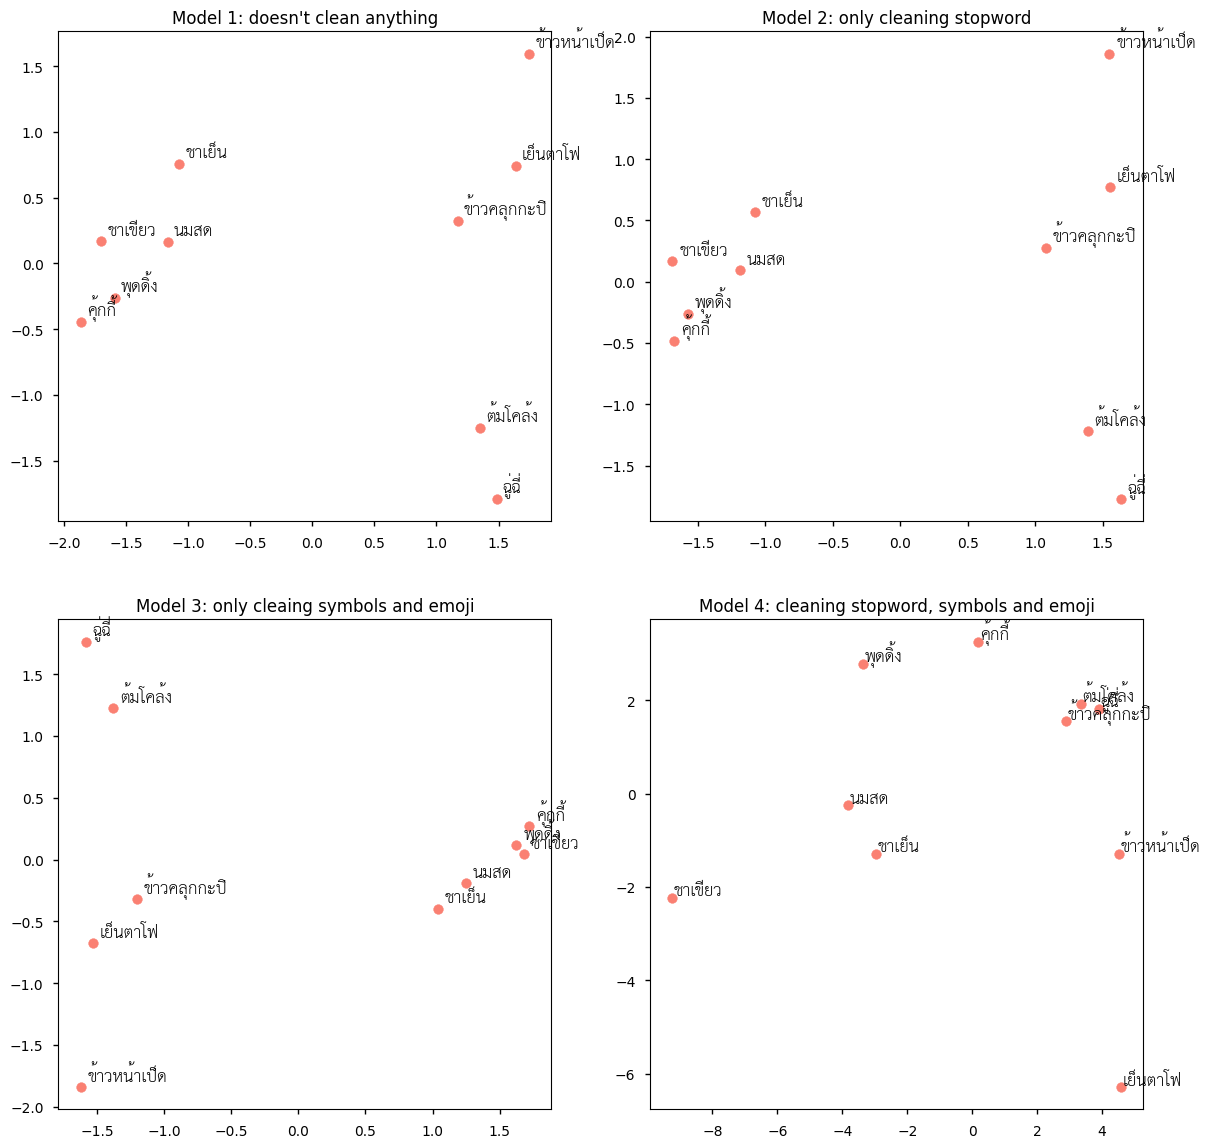

In [33]:
display_plot(words)

6610402230 ศิริสุข ทานธรรม